<a href="https://colab.research.google.com/github/AimjGuytidy/WQU-Thesis/blob/main/time_series_xgboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# forecast monthly births with xgboost
from numpy import asarray
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from matplotlib import pyplot
%matplotlib inline

In [ ]:

# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = concat(cols, axis=1)
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg.values


In [ ]:
 
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test, :], data[-n_test:, :]


In [ ]:
 
# fit an xgboost model and make a one step prediction
def xgboost_forecast(train, testX):
	# transform list into array
	train = asarray(train)
	# split into input and output columns
	trainX, trainy = train[:, :-1], train[:, -1]
	# fit model
	model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
	model.fit(trainX, trainy)
	# make a one-step prediction
	yhat = model.predict(asarray([testX]))
	return yhat[0]


In [ ]:
 
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# split test row into input and output columns
		testX, testy = test[i, :-1], test[i, -1]
		# fit model on history and make a prediction
		yhat = xgboost_forecast(history, testX)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
		# summarize progress
		print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
	# estimate prediction error
	error = mean_absolute_error(test[:, -1], predictions)
	return error, test[:, -1], predictions
 

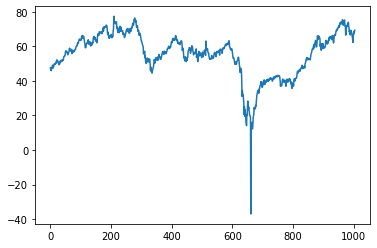

In [ ]:
# load dataset
series = read_csv('/content/trial.csv')
values = series.values
# values
# plot dataset
pyplot.plot(values)
pyplot.show()


In [ ]:

# transform the time series data into supervised learning
data = series_to_supervised(values, n_in=6)
data.shape

(999, 7)

/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


>expected=68.4, predicted=68.1
>expected=67.4, predicted=68.6
>expected=66.5, predicted=68.0
>expected=65.4, predicted=67.3
>expected=63.7, predicted=65.4
>expected=62.2, predicted=63.3
>expected=65.7, predicted=61.3
>expected=67.5, predicted=67.0
>expected=68.5, predicted=66.8
>expected=67.4, predicted=70.0
>expected=68.8, predicted=66.5
>expected=69.3, predicted=69.5
MAE: 1.614


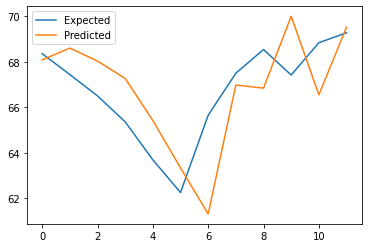

In [ ]:

# evaluate
mae, y, yhat = walk_forward_validation(data, 12)
print('MAE: %.3f' % mae)
# plot expected vs preducted
pyplot.plot(y, label='Expected')
pyplot.plot(yhat, label='Predicted')
pyplot.legend()
pyplot.show()

In [ ]:
DataFrame(data)

,0,1,2,3,4,5,6
0,47.65,46.40,46.46,45.96,47.26,47.32,48.63
1,46.40,46.46,45.96,47.26,47.32,48.63,49.13
2,46.46,45.96,47.26,47.32,48.63,49.13,49.10
3,45.96,47.26,47.32,48.63,49.13,49.10,47.44
4,47.26,47.32,48.63,49.13,49.10,47.44,48.06
...,...,...,...,...,...,...,...
994,67.44,66.50,65.36,63.69,62.25,65.65,67.50
995,66.50,65.36,63.69,62.25,65.65,67.50,68.54
996,65.36,63.69,62.25,65.65,67.50,68.54,67.42
997,63.69,62.25,65.65,67.50,68.54,67.42,68.84


In [ ]:
series.head(10)

,Prices
0,47.65
1,46.40
2,46.46
3,45.96
4,47.26
5,47.32
6,48.63
7,49.13
8,49.10
9,47.44


/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


>expected=53.3, predicted=53.8
>expected=52.2, predicted=53.2
>expected=51.6, predicted=52.9
>expected=50.1, predicted=51.9
>expected=49.6, predicted=51.1
>expected=50.9, predicted=49.0
>expected=50.9, predicted=51.3
>expected=50.3, predicted=50.5
>expected=49.6, predicted=51.2
>expected=50.0, predicted=50.6
>expected=51.1, predicted=50.5
>expected=51.4, predicted=50.7
>expected=52.0, predicted=51.0
>expected=52.1, predicted=52.0
>expected=53.3, predicted=52.0
>expected=53.8, predicted=52.1
>expected=53.4, predicted=54.2
>expected=51.4, predicted=53.6
>expected=49.8, predicted=51.3
>expected=48.7, predicted=48.5
>expected=47.2, predicted=48.6
>expected=44.8, predicted=47.9
>expected=46.8, predicted=45.3
>expected=47.3, predicted=46.8
>expected=46.8, predicted=47.6
>expected=45.9, predicted=47.7
>expected=41.1, predicted=46.1
>expected=31.1, predicted=46.3
>expected=34.5, predicted=31.9
>expected=33.1, predicted=34.1
>expected=31.6, predicted=34.2
>expected=31.7, predicted=32.2
>expecte

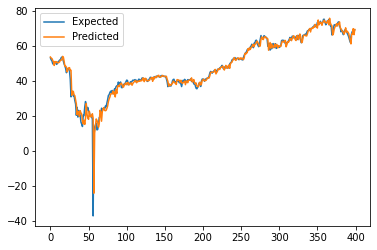

In [ ]:
# evaluate
mae, y, yhat = walk_forward_validation(data, 400)
print('MAE: %.3f' % mae)
# plot expected vs preducted
pyplot.plot(y, label='Expected')
pyplot.plot(yhat, label='Predicted')
pyplot.legend()
pyplot.show()

In [ ]:
train = series_to_supervised(values, n_in=6)
# split into input and output columns
trainX, trainy = train[:, :-1], train[:, -1]
# fit model
model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
model.fit(trainX, trainy)
# construct an input for a new preduction
row = values[-6:].flatten()
# make a one-step prediction
yhat = model.predict(asarray([row]))
print('Input: %s, Predicted: %.3f' % (row, yhat[0]))

Input: [65.65 67.5  68.54 67.42 68.84 69.28], Predicted: 70.496


In [ ]:
series.tail()

,Prices
1000,67.50
1001,68.54
1002,67.42
1003,68.84
1004,69.28


In [ ]:
row = [72.15,71.68,72.37,73.62,73.93,71.31	]
yhat = model.predict(asarray([row]))


In [ ]:
print('Input: %s, Predicted(August 3rd): %.3f' % (row, yhat[0]))

Input: [72.15, 71.68, 72.37, 73.62, 73.93, 71.31], Predicted(August 3rd): 70.596


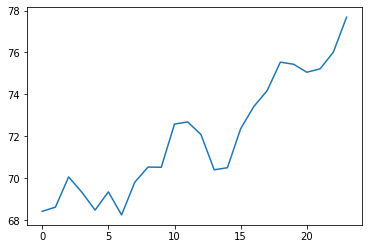

In [ ]:
# load dataset
pred_series = read_csv('/content/predict.csv',header=0,index_col=0,parse_dates=True)
pred_values = pred_series.values
# values
# plot dataset
pyplot.plot(pred_values)
pyplot.show()

In [ ]:
pred_data = series_to_supervised(pred_values, n_in=6)
pred_data

array([[68.43, 68.63, 70.07, 69.34, 68.49, 69.36, 68.26],
       [68.63, 70.07, 69.34, 68.49, 69.36, 68.26, 69.82],
       [70.07, 69.34, 68.49, 69.36, 68.26, 69.82, 70.54],
       [69.34, 68.49, 69.36, 68.26, 69.82, 70.54, 70.53],
       [68.49, 69.36, 68.26, 69.82, 70.54, 70.53, 72.59],
       [69.36, 68.26, 69.82, 70.54, 70.53, 72.59, 72.69],
       [68.26, 69.82, 70.54, 70.53, 72.59, 72.69, 72.09],
       [69.82, 70.54, 70.53, 72.59, 72.69, 72.09, 70.41],
       [70.54, 70.53, 72.59, 72.69, 72.09, 70.41, 70.51],
       [70.53, 72.59, 72.69, 72.09, 70.41, 70.51, 72.37],
       [72.59, 72.69, 72.09, 70.41, 70.51, 72.37, 73.43],
       [72.69, 72.09, 70.41, 70.51, 72.37, 73.43, 74.18],
       [72.09, 70.41, 70.51, 72.37, 73.43, 74.18, 75.54],
       [70.41, 70.51, 72.37, 73.43, 74.18, 75.54, 75.44],
       [70.51, 72.37, 73.43, 74.18, 75.54, 75.44, 75.06],
       [72.37, 73.43, 74.18, 75.54, 75.44, 75.06, 75.22],
       [73.43, 74.18, 75.54, 75.44, 75.06, 75.22, 76.01],
       [74.18,

In [ ]:
pred_input, true_values = pred_data[:, :-1], pred_data[:, -1]
len(pred_input),len(true_values)

(18, 18)

In [ ]:
predicted = []
for row in pred_input:
  k = model.predict(asarray([row]))
  predicted.append(k[0])
predicted

[69.38765,
 67.11713,
 70.1835,
 69.32726,
 70.789024,
 73.58457,
 73.305984,
 72.58673,
 71.02812,
 70.41099,
 72.8925,
 73.47759,
 72.23394,
 75.31145,
 74.88252,
 75.27914,
 75.11127,
 74.137024]

In [ ]:
len(true_values),len(predicted)

(18, 18)

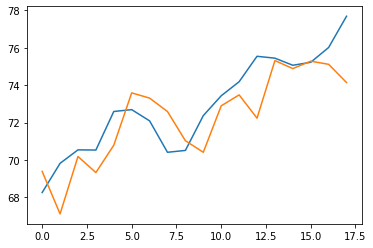

In [ ]:
pyplot.plot(true_values)
pyplot.plot(predicted)
pyplot.show()

In [ ]:
mean_absolute_error(true_values,predicted)

1.294888695610896

In [ ]:
from sklearn.metrics import r2_score
r2_score(true_values,predicted)

0.5610781894737575